## Step 1: Install dependencies

In [ ]:
!pip install librosa soundfile --quiet

## Step 2: Import libraries

In [ ]:
import os
import io
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import Audio, display

## Step 3: Upload the .wav files for 3 diferent instruments manually

In [ ]:
# After running, Colab will open a file picker. Select the files.
# The uploaded dict maps filename -> bytes. We'll save them into /content/uploads/.

data_dir = None
MAX_FILES = 3
upload_folder = '/content/uploads'
os.makedirs(upload_folder, exist_ok=True)

if data_dir is None:
    print(f"Please upload up to {MAX_FILES} audio files (wav).")
    uploaded = files.upload()
    filenames = []
    for fname, filebytes in uploaded.items():
        if len(filenames) >= MAX_FILES:
            print(f"Ignoring extra file: {fname} (already reached {MAX_FILES}).")
            break
        # save to upload_folder
        target_path = os.path.join(upload_folder, fname)
        with open(target_path, 'wb') as f:
            f.write(filebytes)
        filenames.append(target_path)
    if len(filenames) == 0:
        raise SystemExit("No files uploaded. Please upload at least one .wav file.")
else:
    # Read wav files from data_dir
    all_files = []
    for root, _, files_list in os.walk(data_dir):
        for f in files_list:
            if f.lower().endswith('.wav'):
                all_files.append(os.path.join(root, f))
    all_files = sorted(all_files)
    filenames = all_files[:MAX_FILES]
    if len(filenames) == 0:
        raise SystemExit(f"No .wav files found in {data_dir}")

print(f"Files to process ({len(filenames)}):")
for p in filenames:
    print(" -", p)

Please upload up to 3 audio files (wav).


Saving [cel][cla]0001__1.wav to [cel][cla]0001__1.wav
Saving [flu][cla]0346__1.wav to [flu][cla]0346__1.wav
Saving [pia][cla]1283__1.wav to [pia][cla]1283__1.wav
Files to process (3):
 - /content/uploads/[cel][cla]0001__1.wav
 - /content/uploads/[flu][cla]0346__1.wav
 - /content/uploads/[pia][cla]1283__1.wav


## Step 4: Helper function to compute required representations

In [ ]:
# Returns: (y, sr, S_db, S_mel_db, mfccs)
# - S_db: STFT magnitude in dB (normal spectrogram)
# - S_mel_db: Mel-spectrogram in dB
# - mfccs: MFCC matrix (n_mfcc x time frames)

def compute_representations(path, sr=16000, n_fft=2048, hop_length=512, n_mels=128, n_mfcc=20):
    """
    Load audio and compute:
      - STFT magnitude (converted to dB)
      - Mel-spectrogram (dB)
      - MFCCs (from mel-spectrogram)
    """
    # Load audio
    y, sr = librosa.load(path, sr=sr, mono=True)

    # STFT magnitude spectrogram
    # Note: explicit y=y is safer here too, though strictly required for melspectrogram
    S = np.abs(librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    # Mel spectrogram
    # FIX: Pass 'y' as a keyword argument (y=y)
    S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

    # MFCCs
    # We can pass the already computed log-power Mel spectrogram (S_mel_db) to avoid recalculation
    mfccs = librosa.feature.mfcc(S=S_mel_db, n_mfcc=n_mfcc)

    return y, sr, S_db, S_mel_db, mfccs

## Step 5: Plot function - displays the three plots side-by-side

In [ ]:
def plot_three_reps(S_db, S_mel_db, mfccs, sr, hop_length=512, title_prefix=""):
    """
    Plots:
      1) Normal spectrogram (STFT magnitude in dB)
      2) Mel-spectrogram (dB)
      3) MFCC matrix
    """
    plt.figure(figsize=(18, 4))

    # 1. Normal spectrogram
    plt.subplot(1, 3, 1)
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title_prefix} — STFT Spectrogram (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    # 2. Mel-spectrogram
    plt.subplot(1, 3, 2)
    librosa.display.specshow(S_mel_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title_prefix} — Mel-Spectrogram (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel frequency")

    # 3. MFCC
    plt.subplot(1, 3, 3)
    librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar()
    plt.title(f"{title_prefix} — MFCC (n_mfcc x frames)")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC coefficient index")

    plt.tight_layout()
    plt.show()

## Step 6: Compute and display plots for each uploaded file (up to MAX_FILES)


Processing file 1/3: [cel][cla]0001__1.wav


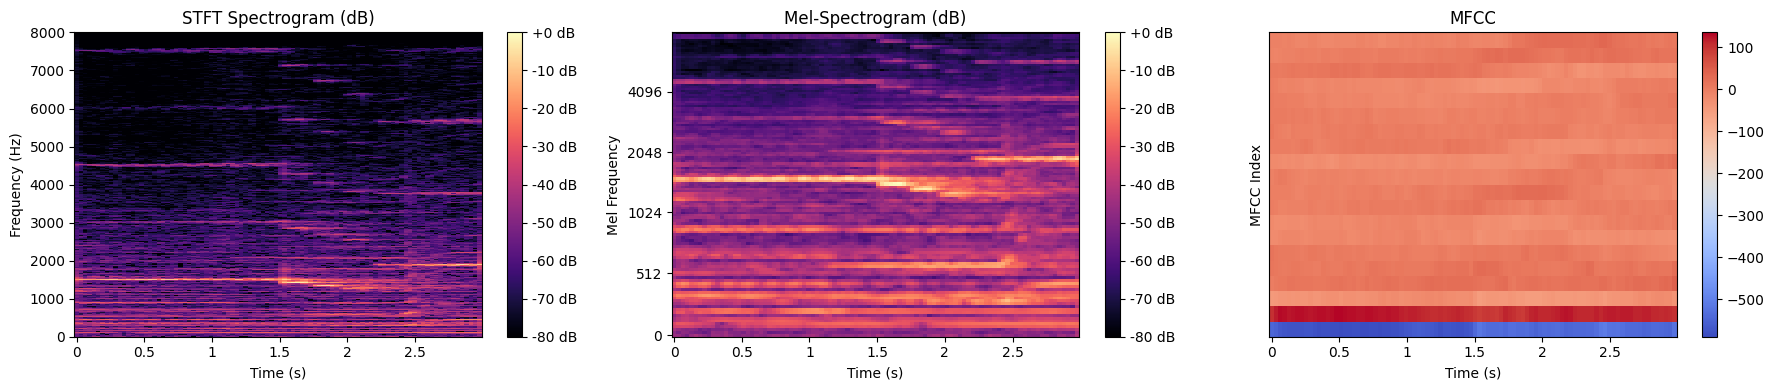

Saved: /content/figures/[cel][cla]0001__1_reprs.png

Processing file 2/3: [flu][cla]0346__1.wav


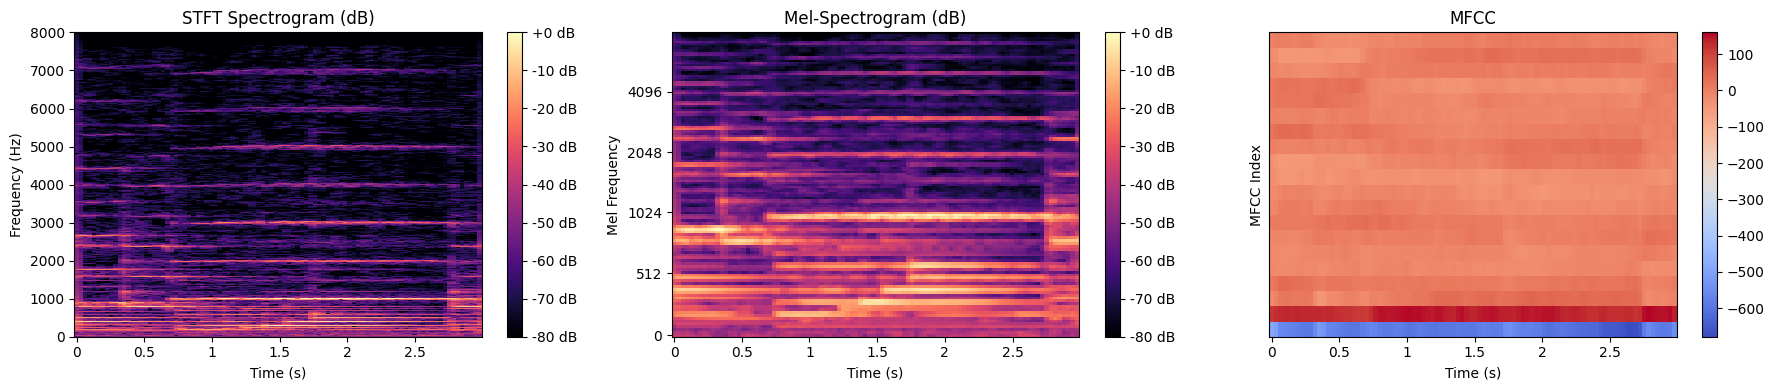

Saved: /content/figures/[flu][cla]0346__1_reprs.png

Processing file 3/3: [pia][cla]1283__1.wav


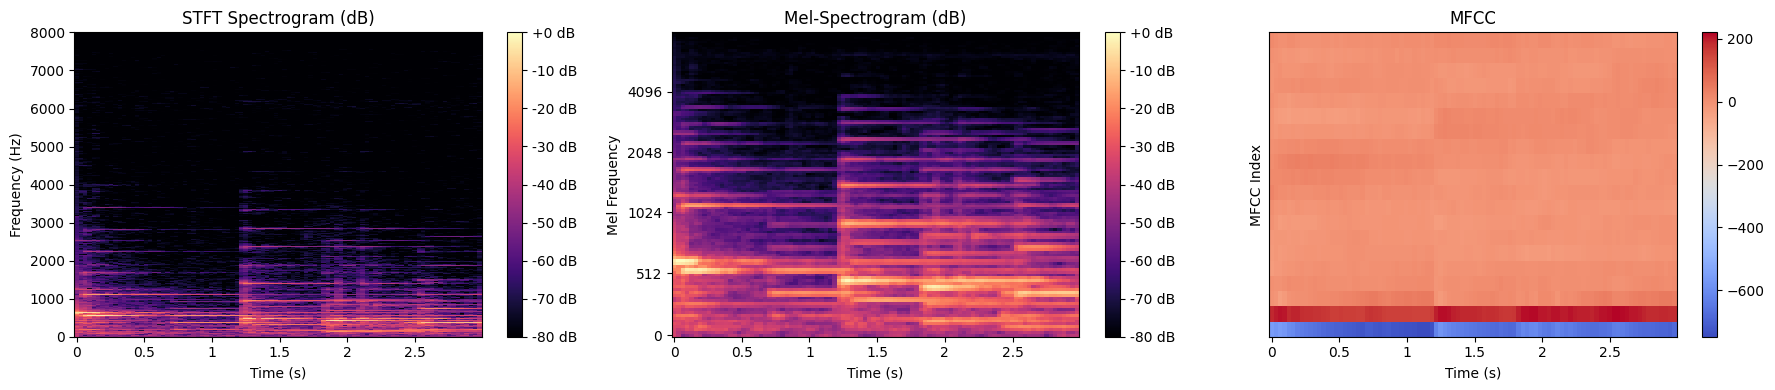

Saved: /content/figures/[pia][cla]1283__1_reprs.png

All figures displayed and saved to: /content/figures


In [ ]:
# Combined: Display and Save Spectrograms in One Loop

HOP_LENGTH = 512
save_dir = "/content/figures"
os.makedirs(save_dir, exist_ok=True)

for idx, path in enumerate(filenames, start=1):
    print(f"\nProcessing file {idx}/{len(filenames)}: {os.path.basename(path)}")

    # Compute features
    y, sr, S_db, S_mel_db, mfccs = compute_representations(
        path,
        sr=16000,                   # <-- Keep consistent
        hop_length=HOP_LENGTH
    )

    # Play the audio
    display(Audio(path))

    # ---------------------------
    # 1) DISPLAY FIGURES
    # ---------------------------
    plt.figure(figsize=(18, 4))

    # STFT Spectrogram
    plt.subplot(1, 3, 1)
    librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title("STFT Spectrogram (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

    # Mel-Spectrogram
    plt.subplot(1, 3, 2)
    librosa.display.specshow(S_mel_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-Spectrogram (dB)")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")

    # MFCC
    plt.subplot(1, 3, 3)
    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar()
    plt.title("MFCC")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Index")

    plt.tight_layout()
    plt.show()

    # ---------------------------
    # 2) SAVE SAME FIGURE
    # ---------------------------
    # Re-create the same figure for saving
    fig = plt.figure(figsize=(18, 4))

    # STFT Spectrogram
    ax1 = fig.add_subplot(1, 3, 1)
    librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB', ax=ax1)
    ax1.set_title("STFT Spectrogram (dB)")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frequency (Hz)")

    # Mel-Spectrogram
    ax2 = fig.add_subplot(1, 3, 2)
    librosa.display.specshow(S_mel_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB', ax=ax2)
    ax2.set_title("Mel-Spectrogram (dB)")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Mel Frequency")

    # MFCC
    ax3 = fig.add_subplot(1, 3, 3)
    librosa.display.specshow(mfccs, sr=sr, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(ax=ax3)
    ax3.set_title("MFCC")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("MFCC Index")

    fig.tight_layout()

    # Save file
    out_path = os.path.join(save_dir, f"{os.path.splitext(os.path.basename(path))[0]}_reprs.png")
    fig.savefig(out_path, dpi=200)
    plt.close(fig)

    print(f"Saved: {out_path}")

print("\nAll figures displayed and saved to:", save_dir)

## Conclusion:
### The STFT spectrogram shows dense, finely resolved horizontal harmonic lines because it preserves the full linear-frequency content of the audio, so instruments with strong harmonic structures exhibit clear, evenly spaced bands across the spectrum.

### The Mel-spectrogram applies perceptual frequency scaling, compressing high-frequency detail and emphasizing low-frequency energy, so the same harmonics appear thicker, smoother, and more clustered, reflecting how human hearing groups frequencies.

### The MFCC plot shows only broad, low-dimensional cepstral patterns rather than visible harmonics because MFCCs discard most spectral detail and retain only the overall timbral envelope of the sound; therefore, the plot appears uniform and coarse, capturing the general tone color rather than the explicit frequency structure seen in the STFT and Mel representations.